In [1]:
from IPython.display import HTML
HTML("<h2>時系列データの読み込み</h2>")

In [2]:
HTML("<p>reference data</p><a target=new href='https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv'>https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv</a>")

In [3]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
from scipy import stats
 
# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline
 
 
# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [4]:
# CSV ファイルを読み込み(1)
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
dataNormal = pd.read_csv(url)
dataNormal.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
"""
[CSV ファイルを読み込み(1)] でデータを読み込むことは可能。
しかし、このやり方だと1列目も「データ」として扱われてしまう。

1列目は単なる日付なので「1列目は日付のインデックスなのだ」と指定をして読み込む必要がある。
また、後ほどSARIMAモデルなどを推定する、データがint型（整数）のままだとエラーに。
→そこで、以下のように読み込みます。
"""
pass

In [6]:
# 日付形式で読み込む（dtype=floatで読み込まないと、あとでARIMAモデル推定時にエラーとなる）
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv(url, index_col='Month', date_parser=dateparse, dtype='float')
data.head()

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [7]:
"""
データは月単位なのですが、それに日数を追加しています（すべて1日目だということに）。
これで日付として扱いやすくなります。

1列だけのデータとなりましたので、わざわざデータフレームで持っておく必要もありません。
乗客数のSeriesだけを取り出して「ts」という名前の変数に格納します。
以降は、この「ts」という変数を使って解析を進めていきます。
"""
pass

In [8]:
# 日付形式にする
ts = data['#Passengers'] 
ts.head()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: #Passengers, dtype: float64

In [9]:
HTML("<h2>時系列データの取り扱い</h2>")

In [10]:
import matplotlib as mpl
mpl.rcParams['font.family'] = ['serif']

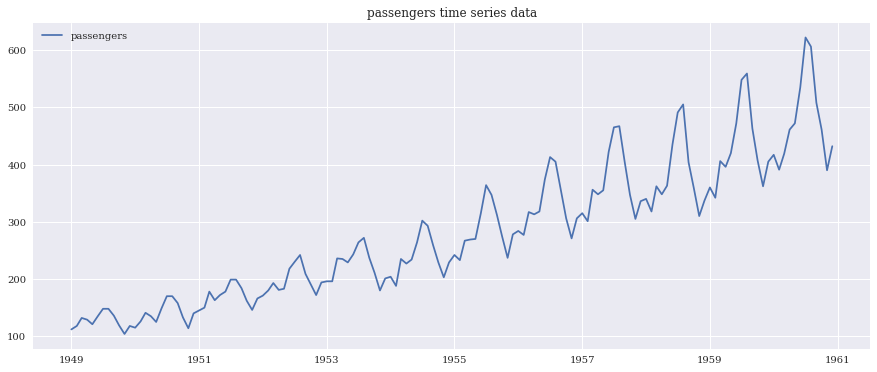

In [11]:
plt.plot(ts, label='passengers')
plt.title('passengers time series data')
plt.legend(loc='best')

In [12]:
"""
グラフを描くと、それだけで様々なことがわかります。
(1) 乗客数が年々増えている。
(2) 季節ごとに乗客数が周期的に変わりそう。

季節変動の有無などは後ほどモデル化するのですが。まずは時系列データの取り扱いに慣れていきましょう。
特定の年月のデータを取得する場合は、以下のようにします。
"""
pass

In [13]:
# データの取得方法その1
ts['1949-01-01']

112.0

In [14]:
 # データの取得方法その2
from datetime import datetime
ts[datetime(1949,1, 1)]

112.0

In [15]:
 # 1949年のデータをすべて取ってくる
ts['1949']

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
1949-06-01    135.0
1949-07-01    148.0
1949-08-01    148.0
1949-09-01    136.0
1949-10-01    119.0
1949-11-01    104.0
1949-12-01    118.0
Name: #Passengers, dtype: float64

In [16]:
from statsmodels.tsa.stattools import adfuller

# Dickey-Fuller test 結果と標準偏差、平均のプロット
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/root/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


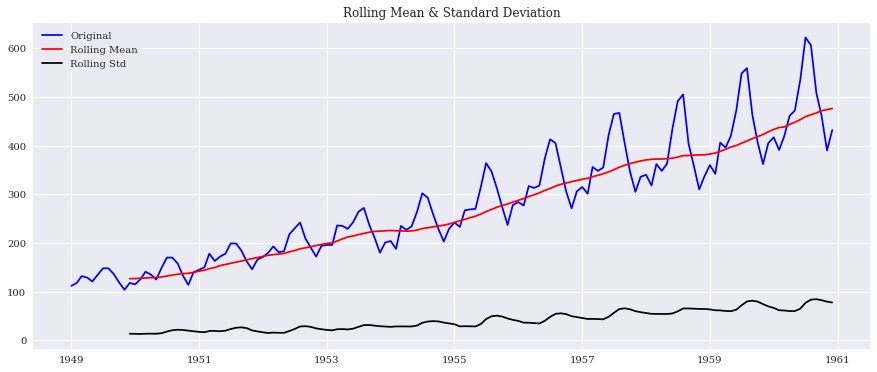

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [17]:
test_stationarity(ts)

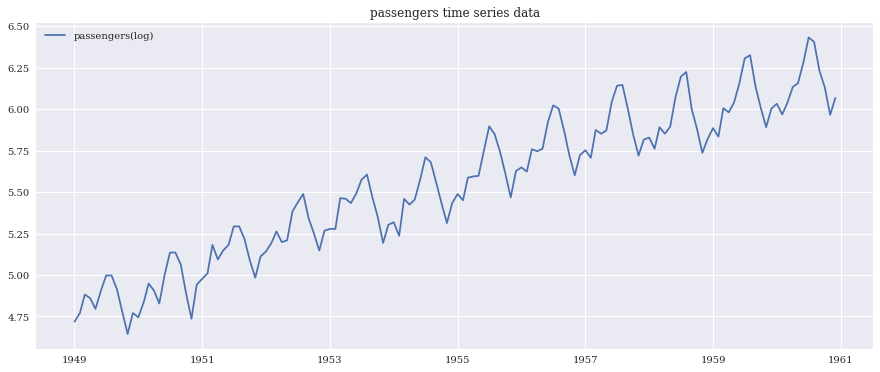

In [18]:
"""
明らかに時系列の後半で、平均値の増加傾向が見て取れる。
→対数をとって変動の削除
"""
ts_log = np.log(ts)
plt.plot(ts_log, label='passengers(log)')
plt.title('passengers time series data')
plt.legend(loc='best')

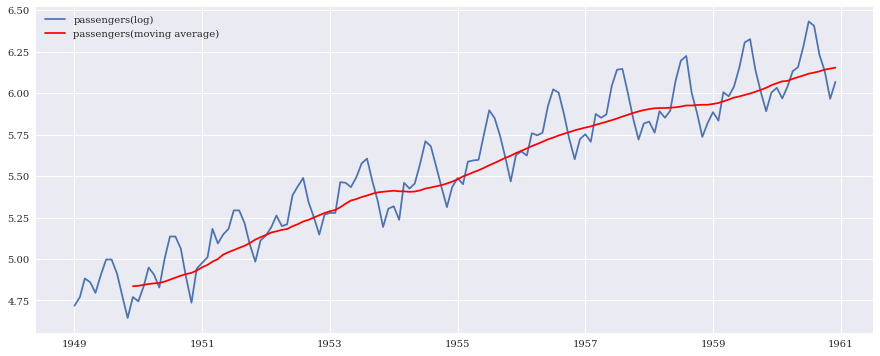

In [19]:
"""
移動平均
対数をとった( ts -> ts_log ) ものから移動平均を計算( ts_log -> moving_avg)
"""
moving_avg = ts_log.rolling(window=12,center=False).mean()
plt.plot(ts_log, label='passengers(log)')
plt.plot(moving_avg, label='passengers(moving average)', color='red')
plt.legend(loc='best')

In [20]:
"""
移動平均を元の系列データから差し引いてみます
注意：直近12個の値の平均値を取るので、最初の11個の値に対して移動平均が
　　　定義されていないことに注意。
"""
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

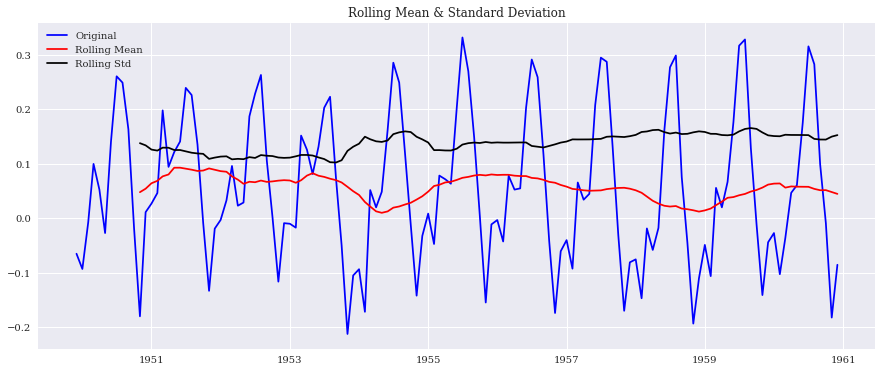

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [21]:
"""
最初の11がNanであることに注目。
これらのNaN値を落として、プロットをチェックして定常性をテストする。
"""
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

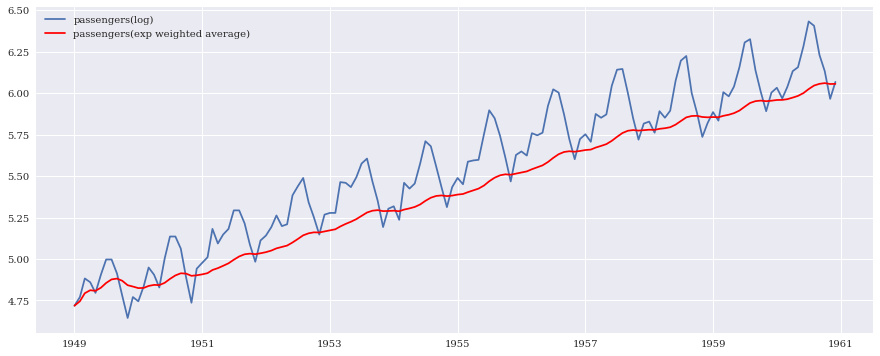

In [22]:
"""
加重移動平均
対数をとった( ts -> ts_log ) ものから加重移動平均を計算( ts_log -> expwighted_avg)
"""
expwighted_avg = ts_log.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
plt.plot(ts_log, label='passengers(log)')
plt.plot(expwighted_avg, label='passengers(exp weighted average)', color='red')
plt.legend(loc='best')

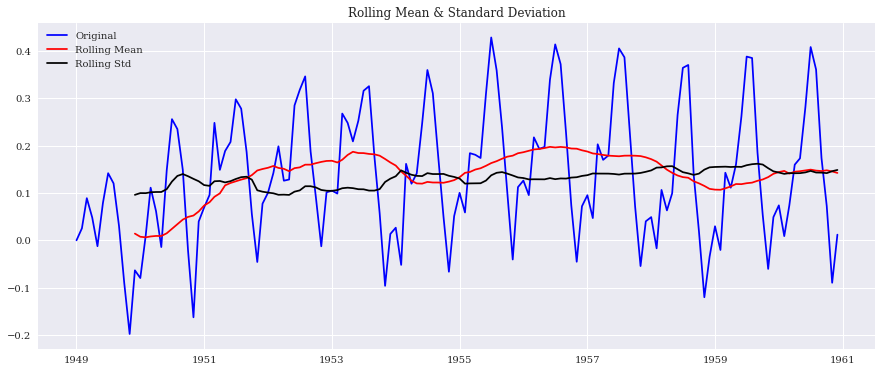

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [23]:
"""
加重移動平均を元の系列データから差し引いてみます
"""
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

In [24]:
"""
データのシフトと差分のとり方

シフトとは、文字通り「データをずらす」こと。
データをずらすことで、データの差分を簡単にとることができるようになります。

例
1949年の2月は1月に比べて「どれほど乗客数が増えたのか」
を調べたい場合は、差分をとればよい。

また時系列解析の場合は、対数差分をとることも多くある。
対数差分は近似的に「変動率」を表す指標となります。
また対数をとることでデータがモデルにフィットしやすくなるというメリットもあります。
今回は対数差分系列は使いませんが、その計算方法だけ確認しておいてください。
"""
pass

In [25]:
# シフトは shift() 関数を適用します。

# 頭だけ取り出し確認
ts.shift().head()

Month
1949-01-01      NaN
1949-02-01    112.0
1949-03-01    118.0
1949-04-01    132.0
1949-05-01    129.0
Name: #Passengers, dtype: float64

In [26]:
# 差分は、シフトする前から、シフトした後を引けばいいです。
diff = ts - ts.shift()

# 頭だけ取り出し確認
diff.head()

Month
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
Name: #Passengers, dtype: float64

In [27]:
# 対数差分は、単に対数をとってから差分するだけ。
logDiff = np.log(ts) - np.log(ts.shift())
logDiff.head()

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: #Passengers, dtype: float64

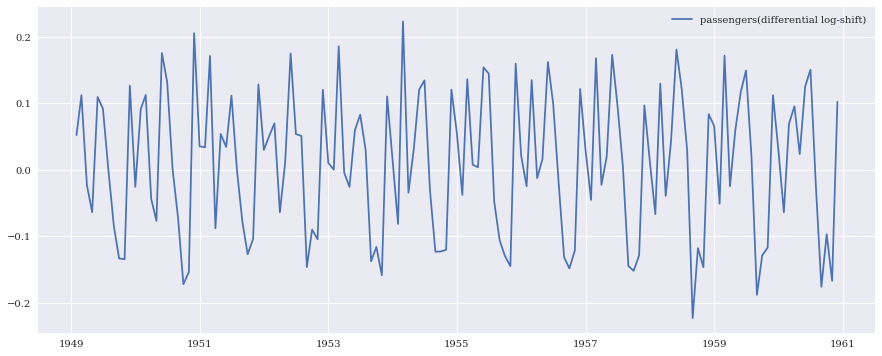

In [28]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff, label='passengers(differential log-shift)')
plt.legend(loc='best')

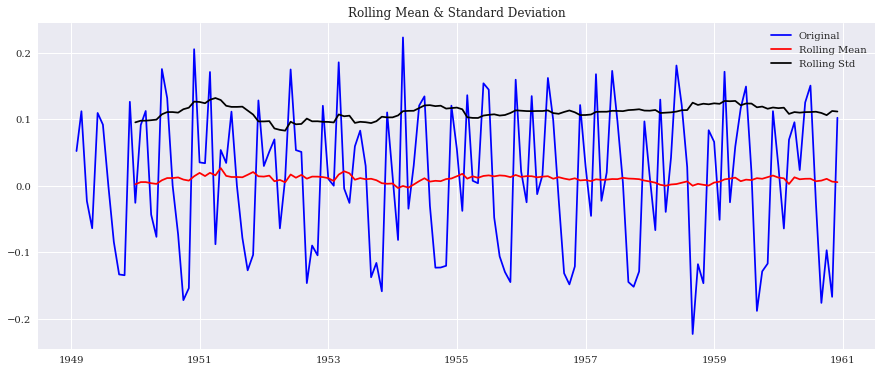

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [29]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

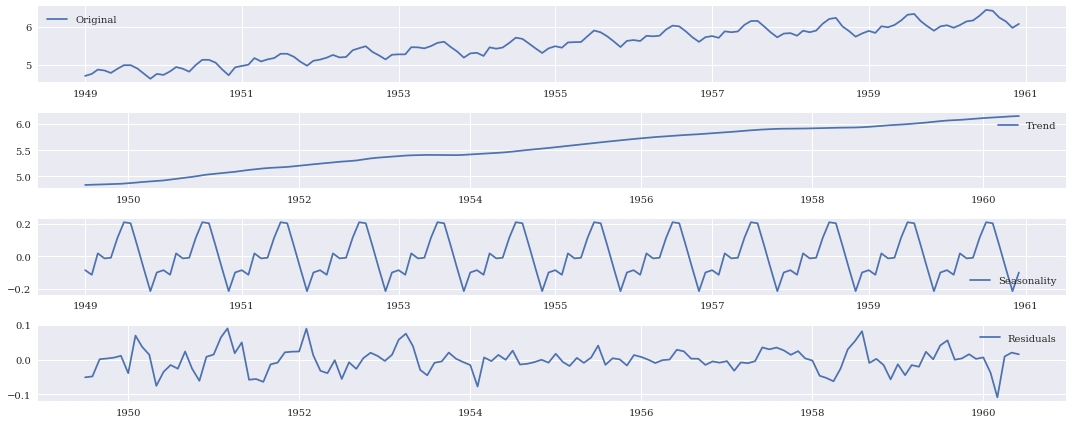

In [30]:
# 傾向(trend)、季節性(seasonal)、残差(residual)に分解してモデル化する。
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


# オリジナルの時系列データプロット
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
 
# trend のプロット
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
 
# seasonal のプロット
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
 
# residual のプロット
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

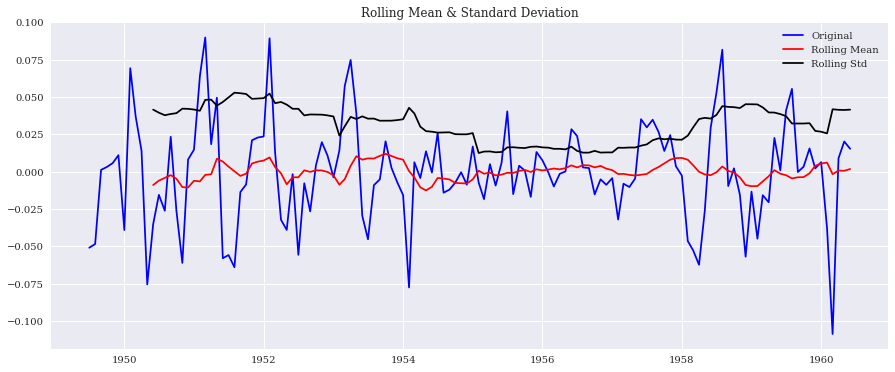

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [31]:
"""
傾向、季節性がデータから分離され、残差をモデル化できることがわかる。
そこで、残差の定常性をチェックできる。
"""
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [32]:
HTML("<h2>自己相関係数の推定</h2>")

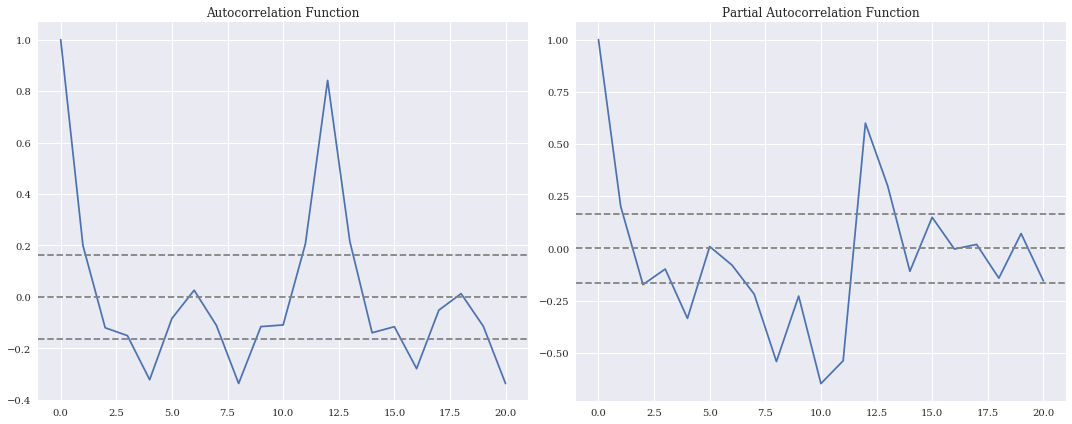

In [33]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [34]:
import statsmodels.api as sm
# 差分系列への自動ARMA推定関数の実行
diff = ts - ts.shift()
diff = diff.dropna()
resDiff = sm.tsa.arma_order_select_ic(diff, ic='aic', trend='nc')
resDiff

{'aic':              0            1            2
 0          NaN  1397.257791  1397.093436
 1  1401.852641  1412.615224  1385.496795
 2  1396.587654  1378.338024  1353.175728
 3  1395.021214  1379.614000  1351.138727
 4  1388.216680  1379.616584  1373.560615, 'aic_min_order': (3, 2)}

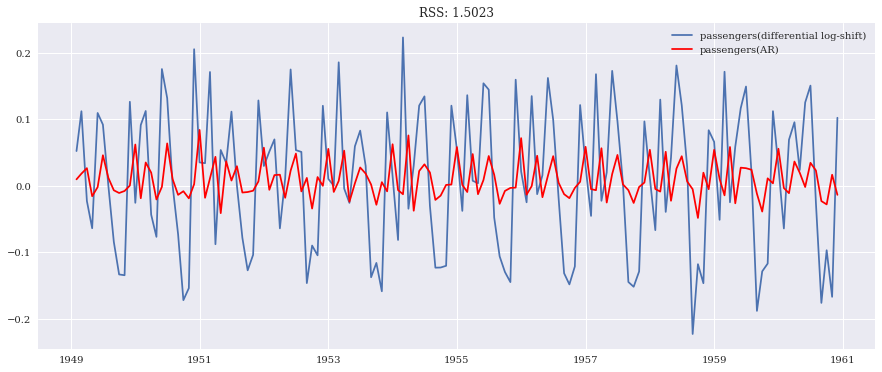

In [35]:
# P-3, q=2 が最善となったので、それをモデル化

# ARモデル　p=2, d=1, q=0を指定。
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  

plt.plot(ts_log_diff, label='passengers(differential log-shift)')
plt.plot(results_AR.fittedvalues, label='passengers(AR)', color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
plt.legend(loc='best')

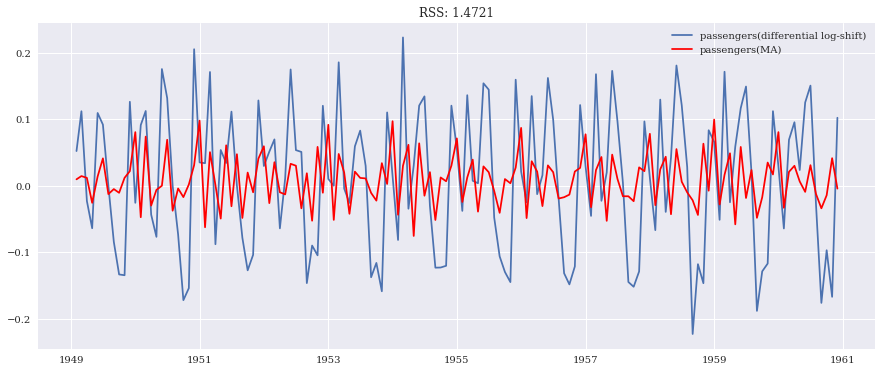

In [36]:
# MA モデル  p=0, d=1, q=2を指定。
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)

plt.plot(ts_log_diff, label='passengers(differential log-shift)')
plt.plot(results_MA.fittedvalues, label='passengers(MA)', color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plt.legend(loc='best')

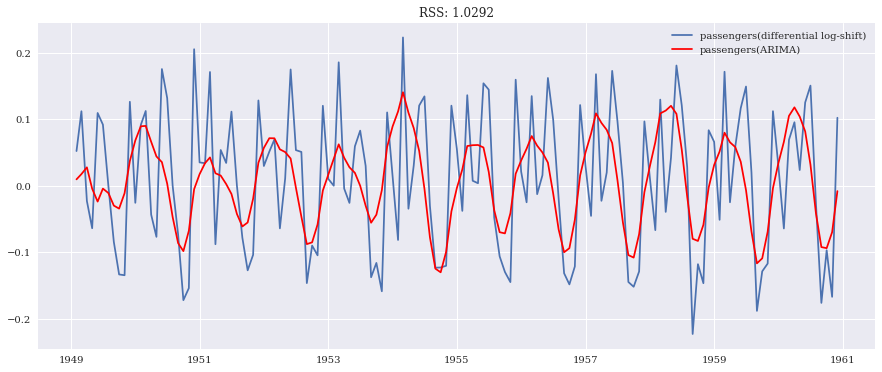

In [37]:
# 結合 モデル  p=2, d=1, q=2を指定。
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)

plt.plot(ts_log_diff, label='passengers(differential log-shift)')
plt.plot(results_ARIMA.fittedvalues, label='passengers(ARIMA)', color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.legend(loc='best')

In [38]:
# もとのデータに戻す
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [39]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [40]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

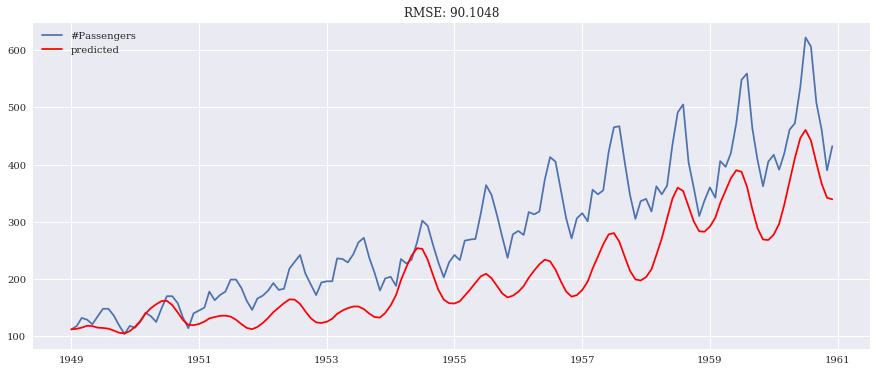

In [41]:
# 季節性変動があるので、うまく予測出来ていない
predictions_ARIMA = np.exp(predictions_ARIMA_log)

plt.plot(ts)
plt.plot(predictions_ARIMA, label='predicted', color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
plt.legend(loc='best')

In [42]:
HTML("<h2>SARIMA モデル</h2><h3>季節変動があるので、SARIMA モデルを適用する。<a target=_blank href='http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html</a></h3>")

In [43]:
# SARIMA モデル
# http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
import statsmodels.api as sm
# P-3, q=2 が最善となったので、それをモデル化

SARIMA_3_1_2_111 = sm.tsa.SARIMAX(ts, order=(3,1,2), seasonal_order=(1,1,1,12)).fit()
print(SARIMA_3_1_2_111.summary())


                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -502.993
Date:                            Fri, 18 Aug 2017   AIC                           1021.986
Time:                                    17:52:53   BIC                           1045.744
Sample:                                01-01-1949   HQIC                          1031.640
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5290    2.3e+08    2.3e-09      1.000    -4.5e+08     4.5e+08
ar.L2          0.2876   1.63e+08   

/root/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [48]:
# 総当たりで、AICが最小となるSARIMAの次数を探す
max_p = 3
max_q = 3
max_d = 1
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_q + 1)*(max_d + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])
pattern

192

In [49]:
# 自動SARIMA選択
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            ts, order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.iloc[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.iloc[num]["aic"] = sarima.aic
                        num = num + 1

/root/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/root/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/root/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/root/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/root/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "

In [51]:
# モデルごとの結果確認
print(modelSelection)
# AIC最小モデル
print(modelSelection[modelSelection.aic == min(modelSelection.aic)])

                             model      aic
0    order=(1,0,0), season=(0,0,0)  1415.91
1    order=(1,0,0), season=(0,0,1)  1205.39
2    order=(1,0,0), season=(0,1,0)  1029.98
3    order=(1,0,0), season=(0,1,1)  944.385
4    order=(1,0,0), season=(1,0,0)  1017.32
5    order=(1,0,0), season=(1,0,1)  1007.03
6    order=(1,0,0), season=(1,1,0)  944.044
7    order=(1,0,0), season=(1,1,1)   945.44
8    order=(1,0,1), season=(0,0,0)  1390.45
9    order=(1,0,1), season=(0,0,1)  1192.29
10   order=(1,0,1), season=(0,1,0)  1014.25
11   order=(1,0,1), season=(0,1,1)  929.433
12   order=(1,0,1), season=(1,0,0)  1009.59
13   order=(1,0,1), season=(1,0,1)  989.176
14   order=(1,0,1), season=(1,1,0)  935.816
15   order=(1,0,1), season=(1,1,1)  935.915
16   order=(1,0,2), season=(0,0,0)  1381.52
17   order=(1,0,2), season=(0,0,1)   1282.3
18   order=(1,0,2), season=(0,1,0)  1009.29
19   order=(1,0,2), season=(0,1,1)  923.304
20   order=(1,0,2), season=(1,0,0)  1010.71
21   order=(1,0,2), season=(1,0,

In [53]:
p=3
d=1
q=3
sp=0
sd=1
sq=1

sarima = sm.tsa.SARIMAX(
    ts, order=(p,d,q), 
    seasonal_order=(sp,sd,sq,12), 
    enforce_stationarity = False, 
    enforce_invertibility = False
).fit()
# 結果確認
print(sarima.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 3)x(0, 1, 1, 12)   Log Likelihood                -441.052
Date:                            Sat, 19 Aug 2017   AIC                            898.105
Time:                                    18:44:32   BIC                            921.863
Sample:                                01-01-1949   HQIC                           907.759
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2231   3336.897  -6.69e-05      1.000   -6540.422    6539.975
ar.L2         -0.1642   4448.807  -

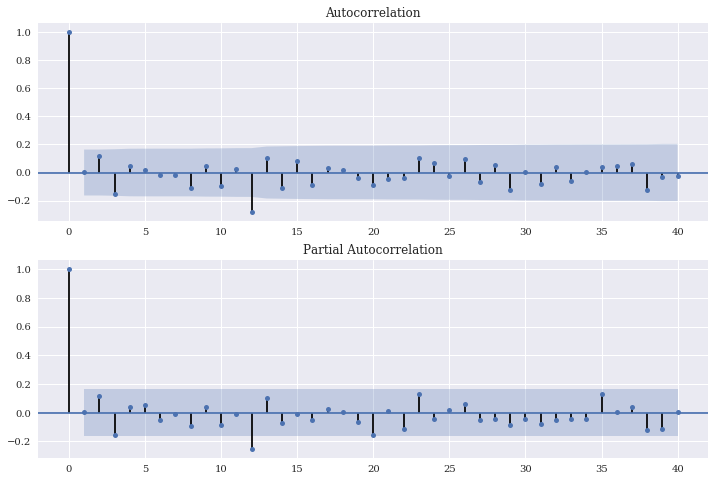

In [55]:
# 残差のチェック
residSARIMA = sarima.resid
fig = plt.figure(figsize=(12,8))

# 自己相関
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=40, ax=ax1)

# 偏自己相関
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

# 残差の自己相関については、ほぼ問題なくなったことを確認

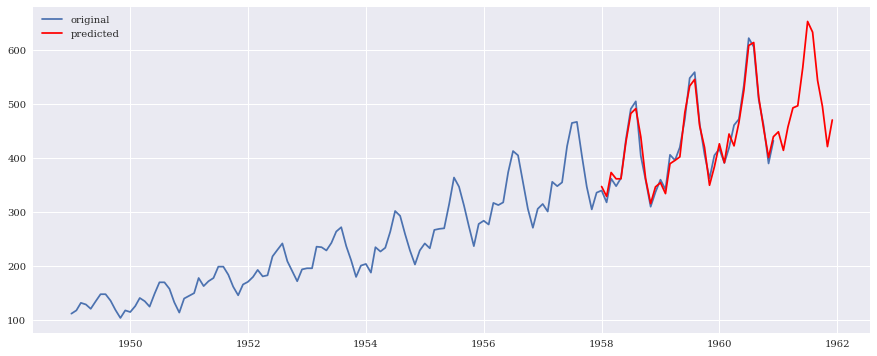

In [56]:
# 予測
ts_pred = sarima.predict('1958-01-01', '1961-12-01')

# 実データと予測結果の図示
plt.plot(ts, label='original')
plt.plot(ts_pred, label='predicted', color='red')
plt.legend(loc='best')